In [ ]:
# Importing required libraries
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import math
import random
import copy
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
IDE = 'Colab' # 'Colab' or 'VSCode
seed = 87+122
def seed_all(seed=87+122):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_all()

## Parameters

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
gamma = 0.99
lr = 1e-3
batch_size = 64
buffer_size = int(1e5)
update_freq = 4
target_update_freq = 50
max_episodes = 100
max_steps = 200
runs = 5
epsilon0 = 0.1
min_epsilon = 0.01
epsilon_decay = 0.999
print_freq = 20
seed_all(seed)

## Dueling DQN

In [ ]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)


In [ ]:
# Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, update_type=1):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)

        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_dim)
        self.update_type = update_type


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)

        if self.update_type == 1:
            q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        elif self.update_type == 2:
            q = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        else:
            raise NotImplementedError("Update type not implemented")

        return q


In [ ]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, update_type=1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.update_type = update_type
        self.q_net = DuelingDQN(state_dim, action_dim, update_type).to(device)
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.steps = 0
        self.replay_buffer = ReplayBuffer(buffer_size)


    def act(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_net(state)
        return q_values.max(dim=-1)[1].item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_net(states)
        next_q_values = self.target_net(next_states).detach()

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(dim=-1)[0]
        target = rewards + gamma * next_q_value * (1 - dones)

        loss = self.loss_fn(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

    def load(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()



## Monte-Carlo REINFORCE

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)


In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class MonteCarloREINFORCEAgent:
    def __init__(self, state_dim, action_dim, baseline=False):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        self.optimizer = optim.Adam(list(self.policy_net.parameters()) + list(self.value_net.parameters()), lr=lr)
        self.baseline = baseline
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy_net(state)
        return torch.distributions.Categorical(probs).sample().item()

    def update(self, trajectory):
        states, actions, rewards = zip(*trajectory)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)

        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns).to(device)

        probs = self.policy_net(states)
        log_probs = torch.log(probs.gather(1, actions.unsqueeze(1)).squeeze(1))

        if self.baseline:
            values = self.value_net(states).squeeze(1)
            advantages = returns - values
            loss = -torch.sum(log_probs * advantages)
            value_loss = self.loss_fn(values, returns)
            loss += value_loss
        else:
            loss = -torch.sum(log_probs * returns)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        return loss.item()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path))


## Trainer

In [ ]:
# Training for Dueling DQN and REINFORCE
class Trainer:
    def __init__(self, env_name, agent_type, update_type=None, baseline=False):
        self.env_name = env_name
        self.agent_type = agent_type
        self.update_type = update_type
        self.baseline = baseline
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.agent = self.get_agent()

    def get_agent(self):
        if self.agent_type == "dueling_dqn":
            return DuelingDQNAgent(self.state_dim, self.action_dim, self.update_type)
        elif self.agent_type == "reinforce":
            return MonteCarloREINFORCEAgent(self.state_dim, self.action_dim, self.baseline)
        else:
            raise NotImplementedError("Agent not implemented")

    def train(self):
        # run for 5 random seeds and average the results
        # reinstaniate the agent for each run
        rewards = np.zeros((runs, max_episodes))
        losses = np.zeros((runs, max_episodes))
        for run in tqdm(range(runs)):
            seed_all(seed+10*run)
            self.agent = self.get_agent()
            rewards[run], losses[run] = self.train_single_run()
        return rewards.mean(axis=0), rewards.std(axis=0), losses.mean(axis=0), losses.std(axis=0)

    def train_single_run(self):
        if self.agent_type == "dueling_dqn":
            return self.train_DuelingDQN()
        elif self.agent_type == "reinforce":
            return self.train_MC_REINFORCE()
        else:
            raise NotImplementedError("Agent not implemented")

    def train_DuelingDQN(self):
        rewards = []
        losses = []
        for episode in range(max_episodes):
            if IDE == 'Colab':
                state = self.env.reset()
            else:
                state, _ = self.env.reset()
            episode_reward = 0
            for step in range(max_steps):
                epsilon = max(min_epsilon, epsilon0 * epsilon_decay**self.agent.steps)
                action = self.agent.act(state, epsilon)
                if IDE == 'Colab':
                    next_state, reward, done, _ = self.env.step(action)
                else:
                    next_state, reward, done, _, _ = self.env.step(action)
                loss = self.agent.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    break
            rewards.append(episode_reward)
            losses.append(loss)
            if episode % print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses

    def train_MC_REINFORCE(self):
        rewards = []
        losses = []
        for episode in range(max_episodes):
            if IDE == 'Colab':
                state = self.env.reset()
            else:
                state, _ = self.env.reset()
            episode_reward = 0
            trajectory = []
            for step in range(max_steps):
                action = self.agent.act(state)
                if IDE == 'Colab':
                    next_state, reward, done, _ = self.env.step(action)
                else:
                    next_state, reward, done, _, _ = self.env.step(action)
                trajectory.append((state, action, reward))
                state = next_state
                episode_reward += reward
                if done:
                    break
            rewards.append(episode_reward)
            loss = self.agent.update(trajectory)
            losses.append(loss)
            if episode % print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses

    def save(self, path):
        self.agent.save(path)

    def load(self, path):
        self.agent.load(path)

In [ ]:
def plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards1, label="Type-1")
    plt.fill_between(np.arange(len(rewards1)), rewards1 - rewards_std1, rewards1 + rewards_std1, alpha=0.3)
    plt.plot(rewards2, label="Type-2")
    plt.fill_between(np.arange(len(rewards2)), rewards2 - rewards_std2, rewards2 + rewards_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Episodic Return")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_losses(losses1, losses_std1, losses2, losses_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(losses1, label="Type-1")
    plt.fill_between(np.arange(len(losses1)), losses1 - losses_std1, losses1 + losses_std1, alpha=0.3)
    plt.plot(losses2, label="Type-2")
    plt.fill_between(np.arange(len(losses2)), losses2 - losses_std2, losses2 + losses_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Hyperparameter Tuning

## Experiments

### Dueling DQN

In [ ]:
# Hyperparameters
gamma = 0.99
lr = 1e-3
batch_size = 64
buffer_size = int(1e5)
update_freq = 4
target_update_freq = 50
max_episodes = 100
max_steps = 200
runs = 5
epsilon0 = 0.1
min_epsilon = 0.01
epsilon_decay = 0.999
print_freq = 20
seed_all(seed)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: -162.0
Episode: 20, Reward: -81.0
Episode: 40, Reward: -104.0
Episode: 60, Reward: -76.0
Episode: 80, Reward: -69.0


 20%|██        | 1/5 [00:51<03:25, 51.29s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -141.0
Episode: 40, Reward: -104.0
Episode: 60, Reward: -136.0
Episode: 80, Reward: -84.0


 40%|████      | 2/5 [01:34<02:19, 46.57s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -130.0
Episode: 40, Reward: -109.0
Episode: 60, Reward: -117.0
Episode: 80, Reward: -75.0


 60%|██████    | 3/5 [02:24<01:36, 48.15s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -124.0
Episode: 40, Reward: -98.0
Episode: 60, Reward: -94.0
Episode: 80, Reward: -92.0


 80%|████████  | 4/5 [03:06<00:45, 45.81s/it]

Episode: 0, Reward: -131.0
Episode: 20, Reward: -121.0
Episode: 40, Reward: -143.0
Episode: 60, Reward: -99.0
Episode: 80, Reward: -88.0


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -104.0
Episode: 60, Reward: -78.0
Episode: 80, Reward: -85.0


 20%|██        | 1/5 [00:42<02:50, 42.75s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -98.0
Episode: 40, Reward: -71.0
Episode: 60, Reward: -82.0
Episode: 80, Reward: -91.0


 40%|████      | 2/5 [01:26<02:09, 43.09s/it]

Episode: 0, Reward: -112.0
Episode: 20, Reward: -118.0
Episode: 40, Reward: -109.0
Episode: 60, Reward: -94.0
Episode: 80, Reward: -87.0


 60%|██████    | 3/5 [02:06<01:23, 41.70s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -139.0
Episode: 40, Reward: -90.0
Episode: 60, Reward: -79.0
Episode: 80, Reward: -80.0


 80%|████████  | 4/5 [02:48<00:42, 42.09s/it]

Episode: 0, Reward: -169.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -126.0
Episode: 60, Reward: -100.0
Episode: 80, Reward: -74.0


100%|██████████| 5/5 [03:33<00:00, 42.67s/it]


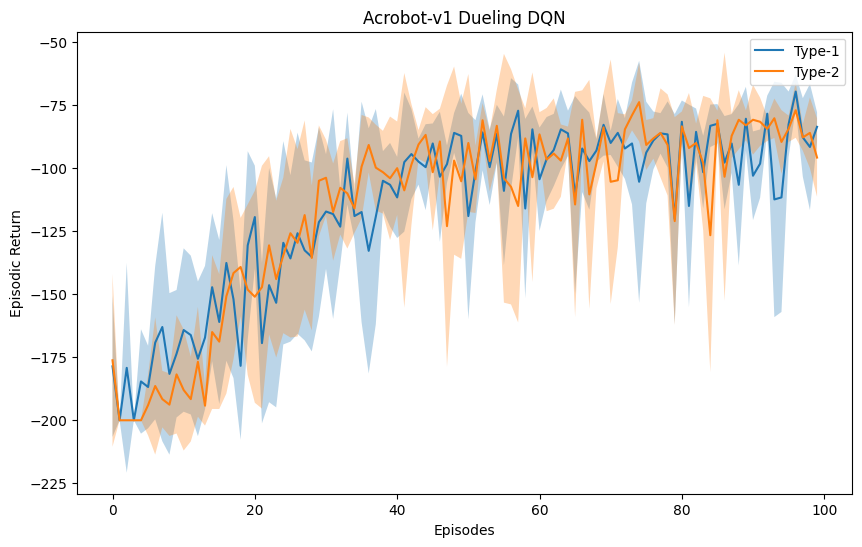

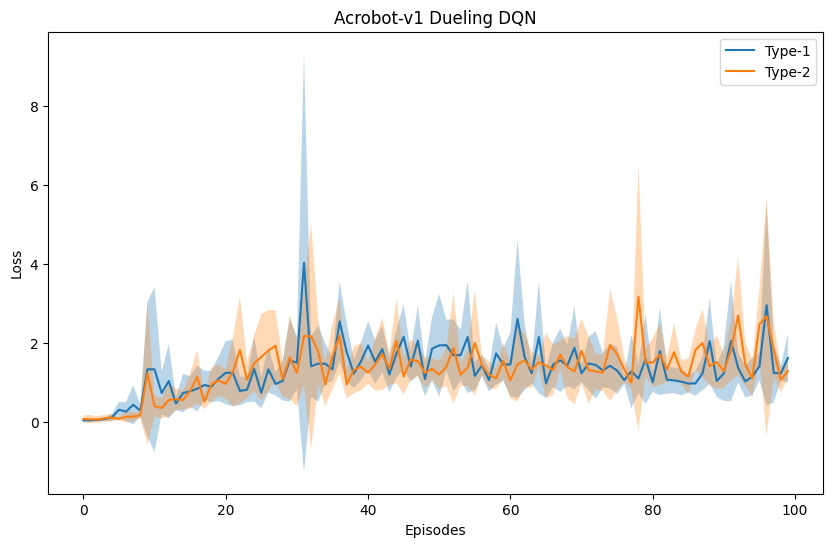

In [ ]:
# Dueling DQN
# Acrobot-v1 using Type-1 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# Acrobot-v1 using Type-2 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_losses")


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 9.0
Episode: 40, Reward: 10.0
Episode: 60, Reward: 164.0
Episode: 80, Reward: 132.0


 20%|██        | 1/5 [00:33<02:13, 33.26s/it]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 10.0
Episode: 40, Reward: 9.0
Episode: 60, Reward: 20.0
Episode: 80, Reward: 146.0


 40%|████      | 2/5 [01:03<01:34, 31.45s/it]

Episode: 0, Reward: 10.0
Episode: 20, Reward: 11.0
Episode: 40, Reward: 9.0
Episode: 60, Reward: 200.0
Episode: 80, Reward: 200.0


 60%|██████    | 3/5 [01:42<01:09, 34.84s/it]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 10.0
Episode: 40, Reward: 9.0
Episode: 60, Reward: 191.0
Episode: 80, Reward: 200.0


 80%|████████  | 4/5 [02:12<00:33, 33.12s/it]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 11.0
Episode: 40, Reward: 12.0
Episode: 60, Reward: 176.0
Episode: 80, Reward: 200.0


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: 10.0
Episode: 20, Reward: 9.0
Episode: 40, Reward: 140.0
Episode: 60, Reward: 131.0
Episode: 80, Reward: 136.0


 20%|██        | 1/5 [00:32<02:09, 32.28s/it]

Episode: 0, Reward: 10.0
Episode: 20, Reward: 10.0
Episode: 40, Reward: 12.0
Episode: 60, Reward: 200.0
Episode: 80, Reward: 200.0


 40%|████      | 2/5 [01:11<01:48, 36.20s/it]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 10.0
Episode: 40, Reward: 159.0
Episode: 60, Reward: 200.0
Episode: 80, Reward: 177.0


 60%|██████    | 3/5 [01:55<01:19, 39.82s/it]

Episode: 0, Reward: 9.0
Episode: 20, Reward: 11.0
Episode: 40, Reward: 162.0
Episode: 60, Reward: 183.0
Episode: 80, Reward: 200.0


 80%|████████  | 4/5 [02:40<00:41, 41.87s/it]

Episode: 0, Reward: 8.0
Episode: 20, Reward: 12.0
Episode: 40, Reward: 200.0
Episode: 60, Reward: 200.0
Episode: 80, Reward: 200.0


100%|██████████| 5/5 [03:42<00:00, 44.54s/it]


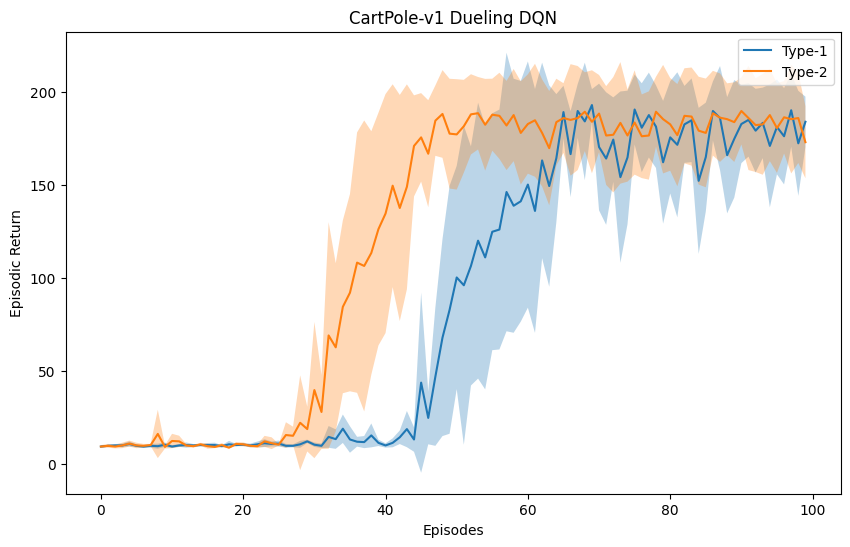

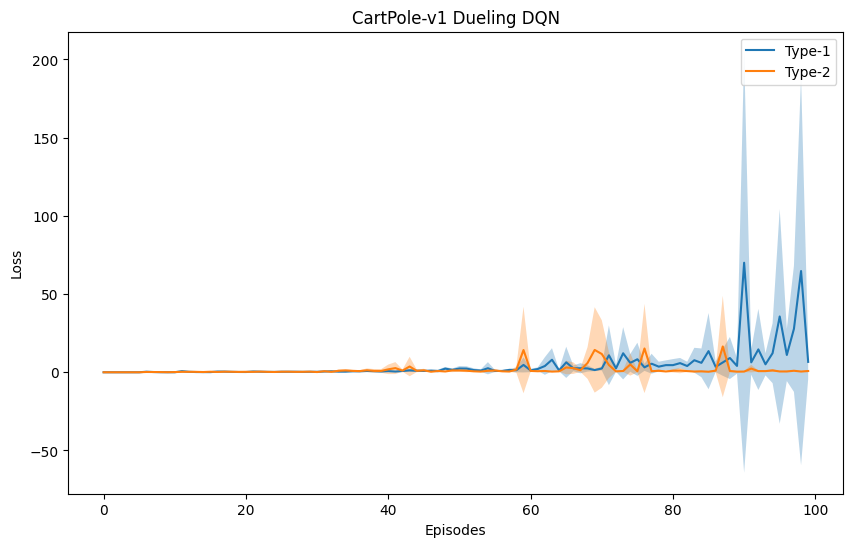

In [ ]:
# Dueling DQN
# CartPole-v1 using Type-1 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# CartPole-v1 using Type-2 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_losses")


### Monte-Carlo REINFORCE

In [ ]:
# Hyperparameters
gamma = 0.99
lr = 1e-3
batch_size = 64
buffer_size = int(1e5)
update_freq = 4
target_update_freq = 50
max_episodes = 100
max_steps = 200
runs = 5
epsilon0 = 0.1
min_epsilon = 0.01
epsilon_decay = 0.999
print_freq = 20
seed_all(seed)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 20%|██        | 1/5 [00:15<01:02, 15.52s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 40%|████      | 2/5 [00:32<00:48, 16.13s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 60%|██████    | 3/5 [00:46<00:30, 15.45s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 80%|████████  | 4/5 [01:01<00:15, 15.13s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -194.0
Episode: 60, Reward: -190.0
Episode: 80, Reward: -159.0


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 20%|██        | 1/5 [00:14<00:58, 14.74s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 40%|████      | 2/5 [00:30<00:45, 15.13s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 60%|██████    | 3/5 [00:45<00:30, 15.08s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -200.0
Episode: 80, Reward: -200.0


 80%|████████  | 4/5 [00:59<00:14, 14.94s/it]

Episode: 0, Reward: -200.0
Episode: 20, Reward: -200.0
Episode: 40, Reward: -200.0
Episode: 60, Reward: -179.0
Episode: 80, Reward: -200.0


100%|██████████| 5/5 [01:14<00:00, 14.93s/it]


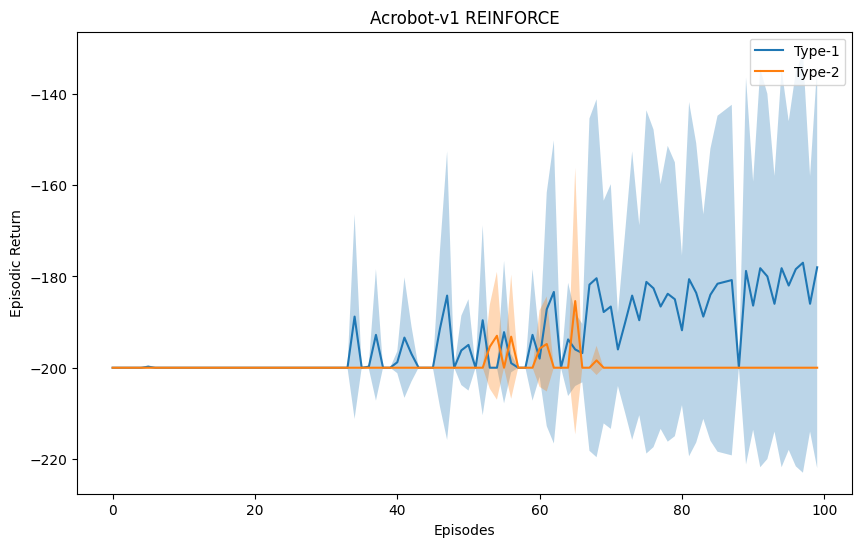

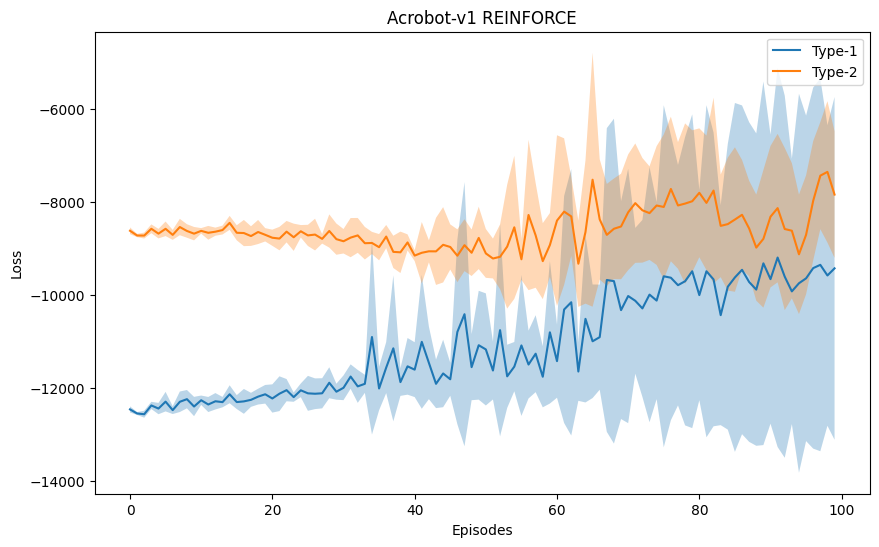

In [ ]:
# Monte Carlo REINFORCE
# Acrobot-v1 without baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# Acrobot-v1 with baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_losses")


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: 35.0
Episode: 20, Reward: 14.0
Episode: 40, Reward: 10.0
Episode: 60, Reward: 14.0
Episode: 80, Reward: 9.0


 20%|██        | 1/5 [00:00<00:03,  1.09it/s]

Episode: 0, Reward: 30.0
Episode: 20, Reward: 28.0
Episode: 40, Reward: 35.0
Episode: 60, Reward: 33.0
Episode: 80, Reward: 200.0


 40%|████      | 2/5 [00:04<00:08,  2.76s/it]

Episode: 0, Reward: 20.0
Episode: 20, Reward: 34.0
Episode: 40, Reward: 36.0
Episode: 60, Reward: 23.0
Episode: 80, Reward: 107.0


 60%|██████    | 3/5 [00:08<00:06,  3.24s/it]

Episode: 0, Reward: 16.0
Episode: 20, Reward: 16.0
Episode: 40, Reward: 15.0
Episode: 60, Reward: 13.0
Episode: 80, Reward: 30.0


 80%|████████  | 4/5 [00:10<00:02,  2.84s/it]

Episode: 0, Reward: 13.0
Episode: 20, Reward: 13.0
Episode: 40, Reward: 11.0
Episode: 60, Reward: 19.0
Episode: 80, Reward: 96.0


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: 69.0
Episode: 20, Reward: 17.0
Episode: 40, Reward: 12.0
Episode: 60, Reward: 40.0
Episode: 80, Reward: 64.0


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

Episode: 0, Reward: 31.0
Episode: 20, Reward: 11.0
Episode: 40, Reward: 25.0
Episode: 60, Reward: 32.0
Episode: 80, Reward: 200.0


 40%|████      | 2/5 [00:05<00:08,  2.96s/it]

Episode: 0, Reward: 23.0
Episode: 20, Reward: 55.0
Episode: 40, Reward: 61.0
Episode: 60, Reward: 43.0
Episode: 80, Reward: 47.0


 60%|██████    | 3/5 [00:09<00:06,  3.47s/it]

Episode: 0, Reward: 16.0
Episode: 20, Reward: 18.0
Episode: 40, Reward: 38.0
Episode: 60, Reward: 49.0
Episode: 80, Reward: 25.0


 80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

Episode: 0, Reward: 11.0
Episode: 20, Reward: 13.0
Episode: 40, Reward: 34.0
Episode: 60, Reward: 52.0
Episode: 80, Reward: 87.0


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


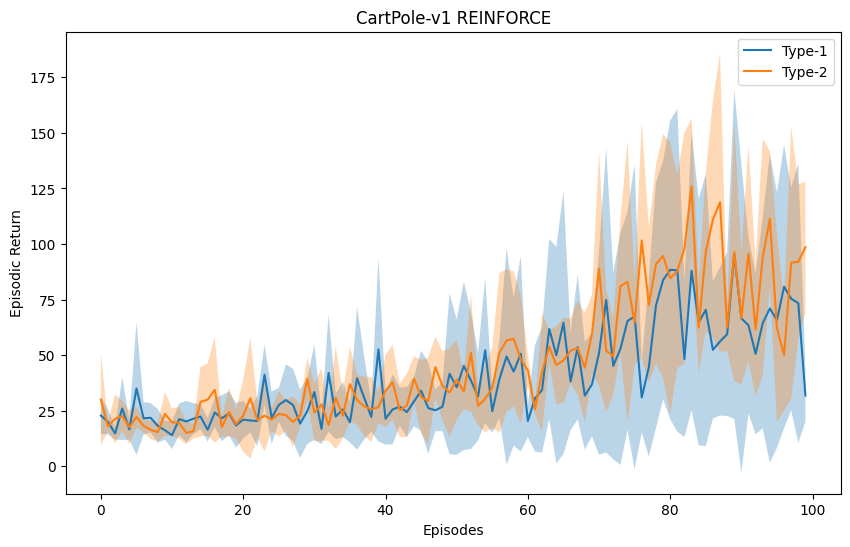

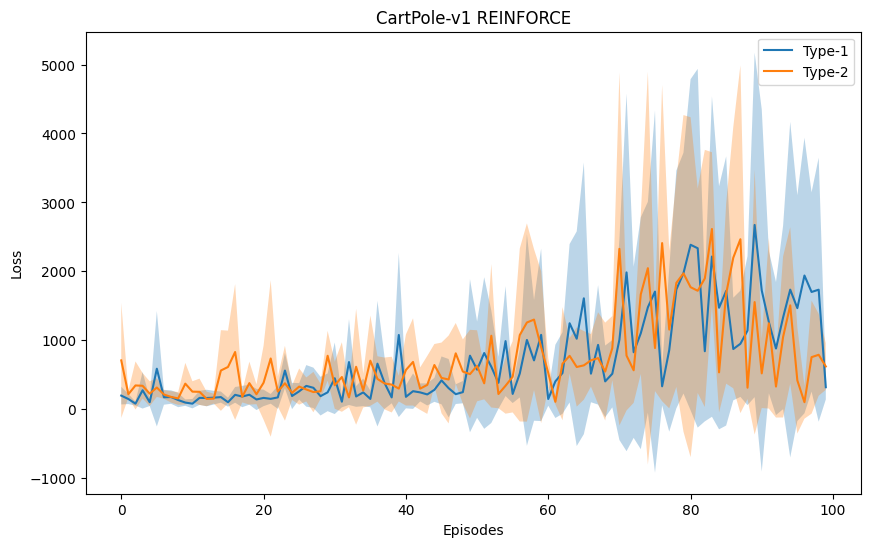

In [ ]:
# Monte Carlo REINFORCE
# CartPole-v1 without baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# CartPole-v1 with baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_losses")
